In [30]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#Constant
SEED = 123
IMAGE_SIZE = 256
BATCH_SIZE  = 32
COLOR_CHANNEL = 3
EPOCHS = 32

In [3]:
#loading the data set 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

dataset.take(1)

Found 2152 files belonging to 3 classes.


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
#class name 
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 2 1 0 1 1 1 2]


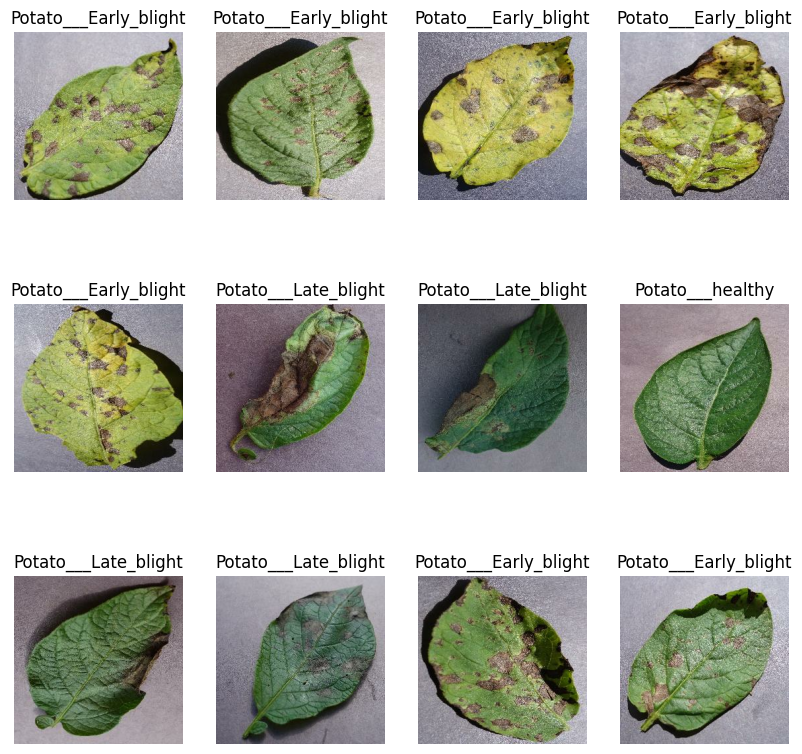

In [ ]:
#length of dataset
len(dataset) 
#prints 68 it is the number of batches you can have 
#68 * 3 = 2176, but the last batch might be smaller so the exact count might be less or equal to this


#shape of img and numeric label for each img in batch 
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) # (Batch, height, width, color channel)
    print(label_batch.numpy()) # gives the class ID for each image in that batch. Using the given ID  you can look up the class name

#display the img
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
#splitting dataset hard coded
# train_size = 0.8
# len(dataset)*train_size #54
# train_ds = dataset.take(54)#training set 80% 

# val_size = 0.1
# len(dataset)*val_size #6
# val_ds = dataset.take(6) #validation set 10%

# test_ds = dataset.skip(6) #test set 10%


In [7]:
#splitting dataset function 

def get_dataset_split(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=SEED)

    train_size = int(train_split * dataset_size) #gets 80% of 68 
    val_size = int(val_split * dataset_size) #gets 10% of 68

    train_dataset = dataset.take(train_size) #stores 80% of the data

    val_dataset = dataset.skip(train_size).take(val_size) #stores 10% of the data

    test_dataset= dataset.skip(train_size).skip(val_size) #stores 10% of the data

    return train_dataset, val_dataset, test_dataset 

In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_split(dataset) #setting the vals into train, validation and test 

In [65]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset  = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
#scaling the img


resize_and_rescale = tf.keras.layers.Cropping2D(
    cropping = (IMAGE_SIZE, IMAGE_SIZE)
)

resize_and_rescale = tf.keras.layers.Rescaling(
    scale = 1/225
)

#data augmentationca

data_augmentation = tf.keras.layers.RandomFlip(
    seed = SEED
)
data_augmentation = tf.keras.layers.RandomRotation(
    factor = 0.2,
    seed = SEED
)


In [11]:
input_shape = (BATCH_SIZE ,IMAGE_SIZE, IMAGE_SIZE, COLOR_CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

model.build(input_shape=input_shape)

c:\Users\Bisho\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (32, 256, 256, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/20


In [ ]:
scores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.9844 - loss: 0.0540


[0.05401776358485222, 0.984375]

In [18]:
history.params #paramaters of model 

history.history.keys() #what is storied in history

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

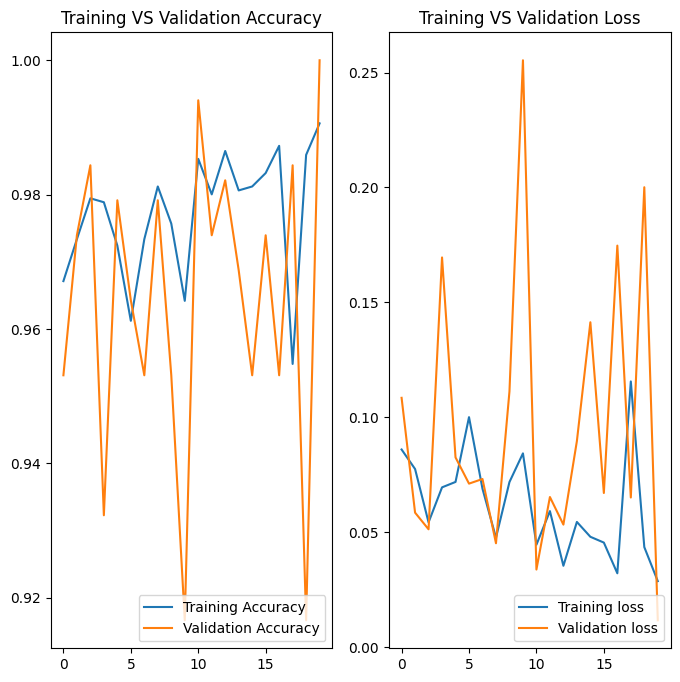

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training VS Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation loss")
plt.legend(loc = "lower right")
plt.title("Training VS Validation Loss")
plt.show()

First image to predict
First image's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Potato___Early_blight


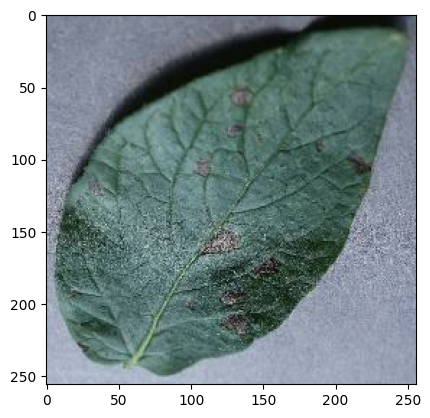

In [38]:
for image_batch, label_batch in test_dataset.take(1):

    first_image = image_batch[0].numpy().astype("uint8") #RGB of the first image
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)#all 32 prediction for this batch
    print(class_names[np.argmax(batch_prediction[0])])#prediction of the first batch

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


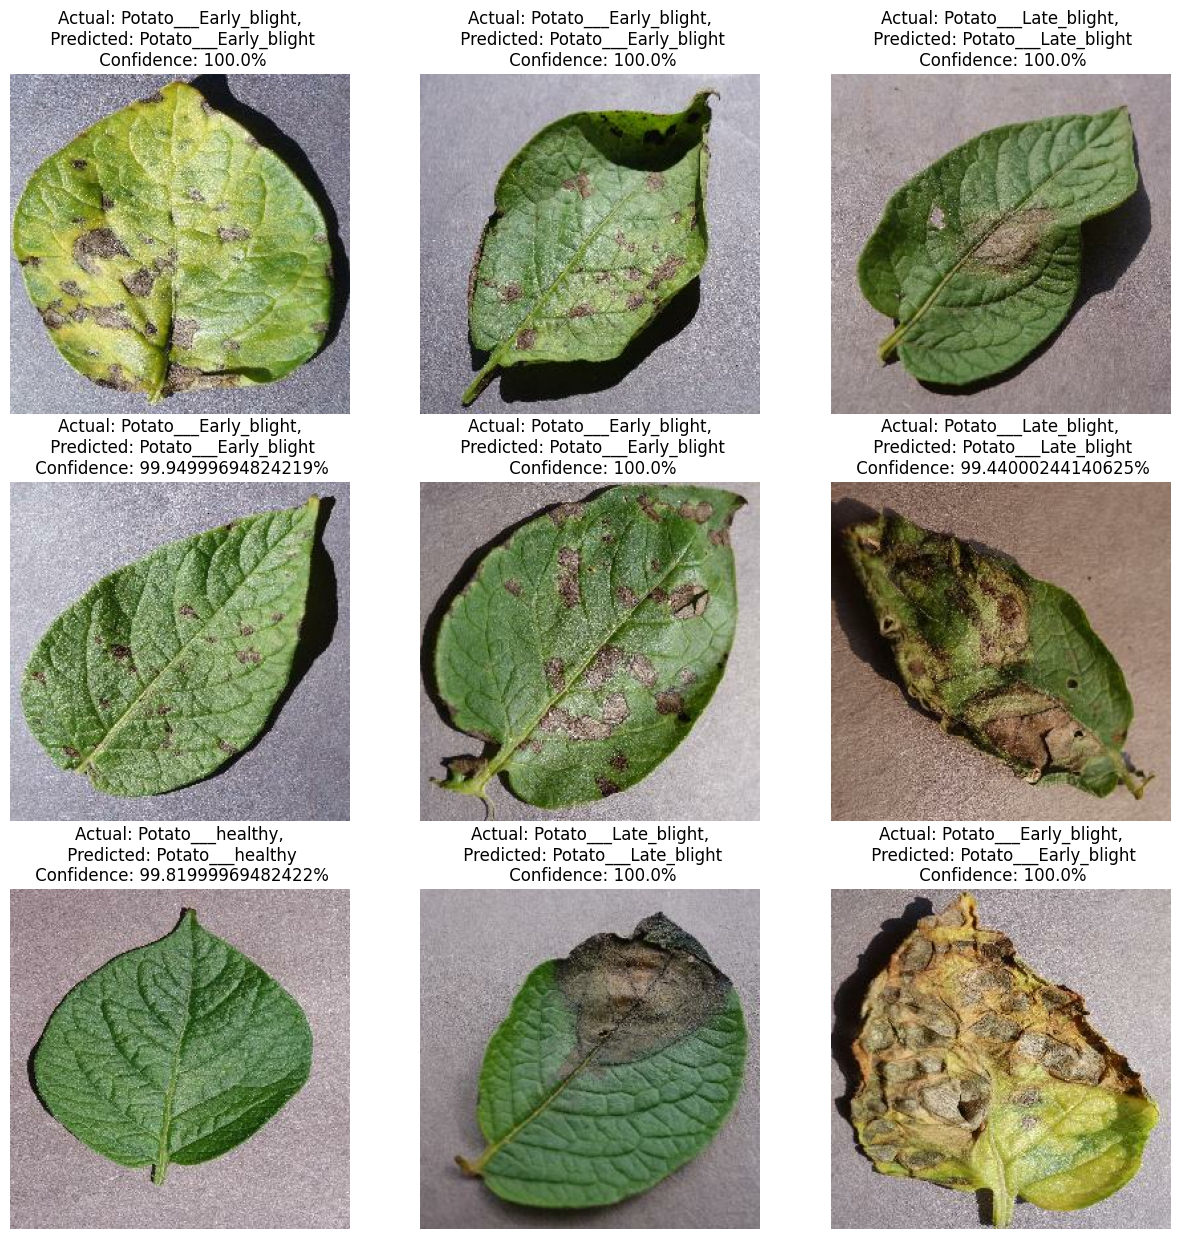

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence: {confidence}%")

        plt.axis("off")

In [64]:
import os

model_version = "1"

# Make sure the parent models folder exists
models_root = "../models"
os.makedirs(models_root, exist_ok=True)

export_path = os.path.join(models_root, model_version)

# This creates a SavedModel directory: assets/, variables/, saved_model.pb, etc.
model.export(export_path)


INFO:tensorflow:Assets written to: ../models\1\assets


INFO:tensorflow:Assets written to: ../models\1\assets


Saved artifact at '../models\1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1840320093200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320095888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320097040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320096656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320097424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320096080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320097616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320096272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320098192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320095696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840320098384: TensorSpec(shape=(), dty